<h1> <div align="center"><a> Проект «Рекомендация тарифов для телеком-компании» </a></div>

## Откройте и изучите файл

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix

In [2]:
df = pd.read_csv("/datasets/users_behavior.csv")
display(df.head())

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
#оценим общий массив данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Общая выборка имеет 3214 строк и 5 столбцов. Пропущенных значений нет, изменять тип данных необходимости нет.

In [4]:
#проверим сбалансированность выборки по целевому признаку
df["is_ultra"].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Количество пользователей тарифом "Смарт" более чем в 2 раза превышает количество пользователей "Ультра". Налицо несбалансированность данных. Однако поскольку на данный момент у нас нет инструментов работы с несбалансированными выборками, пока просто отметим этот факт как особенность.

             calls   minutes  messages   mb_used
calls     1.000000  0.982083  0.177385  0.286442
minutes   0.982083  1.000000  0.173110  0.280967
messages  0.177385  0.173110  1.000000  0.195721
mb_used   0.286442  0.280967  0.195721  1.000000


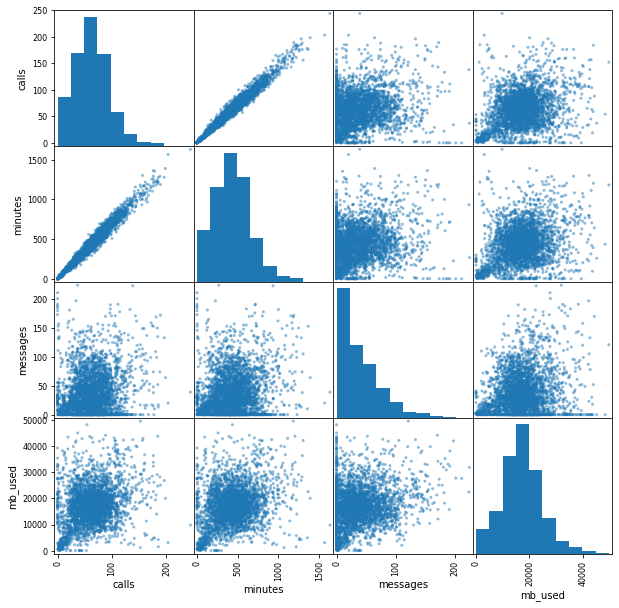

In [5]:
#построим корреляционную матрицу признаков и диграммы рассеивания для них
features = df.drop('is_ultra', axis=1)
print(features.corr()) 
pd.plotting.scatter_matrix(features, figsize=(10, 10))
plt.show()

**Налицо полная коллинеарность количества звонков и использованных минут.  Чтобы избежать неопределенности значений параметров, мы можем исключить один из признаков для дальнейшего анализа. Поскольку правила тарифов привязаны к количеству минут, то лучше исключить звонки.**

In [6]:
df = df.drop('calls', axis=1)

## Разбейте данные на выборки

Спрятанной тестовой выборки нет. Значит, данные нужно разбить на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные пошагово разобьем в соотношении 3:1:1.

In [7]:
df_train, df_middle = train_test_split(df, test_size=0.4, random_state=12345)
display(df_train.shape)
display(df_middle.shape)

(1928, 4)

(1286, 4)

In [8]:
df_valid, df_test = train_test_split(df_middle, test_size=0.5, random_state=12345)
display(df_valid.shape)
display(df_test.shape)

(643, 4)

(643, 4)

## Исследуйте модели

In [9]:
#объявим переменные с признаками и целевым признаком для каждой из полученных выборок
features_train = df_train.drop(['is_ultra'], axis = 1)
target_train = df_train['is_ultra']
features_valid = df_valid.drop(['is_ultra'], axis = 1)
target_valid = df_valid['is_ultra']
features_test = df_test.drop(['is_ultra'], axis = 1)
target_test = df_test['is_ultra']

In [10]:
#сначала обучим модель с помощью алгоритма решающего дерева, варьируя гиперпараметр "Максимальная глубина"
best_result = 0
for depth in range(1, 6):
    model_1 = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_1.fit(features_train, target_train)
    result = model_1.score(features_valid, target_valid)
    if result > best_result:
        best_result = result
        best_depth = depth
print("Accuracy наилучшей модели на валидационной выборке:", best_result, "Максимальная глубина:", best_depth)

Accuracy наилучшей модели на валидационной выборке: 0.7884914463452566 Максимальная глубина: 4


In [11]:
#теперь построим модель с помощью алгоритма случайного леса, изменяя гиперпараметры "Количество деревьев" и "Максимальная глубина"
best_result = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model_2 = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model_2.fit(features_train, target_train) 
        result = model_2.score(features_valid, target_valid)
        if result > best_result:
            best_result = result
            best_est = est
            best_depth = depth
print("Accuracy наилучшей модели на валидационной выборке:", best_result, "Количество деревьев:", best_est, "Максимальная глубина:", best_depth)

Accuracy наилучшей модели на валидационной выборке: 0.7993779160186625 Количество деревьев: 20 Максимальная глубина: 8


In [12]:
#наконец построим модель с помощью логистической регрессии
model_3 = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=100) 
model_3.fit(features_train, target_train)
result = model_3.score(features_valid, target_valid)
print("Accuracy на валидационной выборке:", result)

Accuracy на валидационной выборке: 0.7076205287713841


**Мы видим, что наибольшую точность на валидационной выборке (почти 80%) нам дала модель, построенная с помощью алгоритма случайный лес со следующими гиперпараметрами: количество деревьев: 20, максимальная глубина: 8.** Немного хуже проявила себя модель дерева решений с максимальной глубиной 4 - accuracy 79%, что, однако, превышает требуемые 75% точности. Наименьшую точность показала модель логистической регрессии - 71%.

## Проверьте модель на тестовой выборке

In [13]:
#проверим модель случайного леса с найденными гиперпараметрами на тестовой выборке
model_final = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=8)
model_final.fit(features_train, target_train) 
model_final.score(features_test, target_test)

0.80248833592535

👍

**По итогам проверки выбранной модели на тестовой выборке мы получили высокий уровень accuracy (80%)**, что практически не отличается от результатов для валидационной выборки и превышает необходимый уровень accuracy 75%.

## Проверка модели на адекватность

Чтобы оценить адекватность модели, проверим, как часто в целевом признаке встречается класс «1» или «0».

In [14]:
df['is_ultra'].value_counts() / df.shape[0]

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Почти в 70% случаев мы получаем 0. Аналогичный результат мы получим, если бы будем использовать константную модель, которая любому объекту прогнозирует класс «0».

In [24]:
dc = DummyClassifier(strategy='most_frequent', random_state=12345).fit(features_train, target_train) 
#dc.fit(features_train, target_train) 
y_pred = dc.predict(features_test)
dc.score(features_test, target_test)

0.6842923794712286

Таким образом, **если обученная модель сможет ПРАВИЛЬНО предсказать 0 и 1 лучше, чем константная модель, ее можно считать адекватной для последующего использования**. Построим матрицу ошибок для выбранной модели.

array([[405,  35],
       [ 92, 111]])

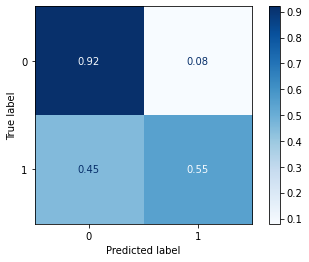

In [15]:
display(confusion_matrix(target_test, model_final.predict(features_test)))
plot_confusion_matrix(estimator=model_final, X=features_test, y_true=target_test,
                      normalize="true", cmap="Blues")
plt.show()

**На основании матрицы ошибок мы видим, что выбранная нами модель на 23% лучше в предсказании тарифа Смарт и на 24% лучше в предсказании тарифа Ультра. Таким образом, наша модель прошла тест на адекватность и ее можно использовать для прогнозирования.**